Imports
---------

In [349]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [350]:
raw_df = pandas.read_csv('./movie_metadata.csv')

In [351]:
raw_df.head()

,duration,num_voted_users,num_critic_for_reviews,movie_facebook_likes,imdb_score,budget,gross,title_year,director_name,movie_title
0,178.0,886204.0,NaN,33000.0,7.9,NaN,760505847.0,2009.0,James Cameron,Avatar
1,169.0,471220.0,302.0,0.0,NaN,300000000.0,309404152.0,2007.0,Gore Verbinski,Pirates of the Caribbean: At World's End
2,148.0,275868.0,602.0,85000.0,6.8,NaN,200074175.0,2015.0,Sam Mendes,Spectre
3,164.0,1144337.0,813.0,164000.0,8.5,250000000.0,448130642.0,2012.0,Christopher Nolan,The Dark Knight Rises
4,NaN,8.0,NaN,0.0,7.1,NaN,NaN,NaN,Doug Walker,Star Wars: Episode VII - The Force Awakens ...


Cleaning the data
---------------------

From a first glance, it looks like many of the entries have missing input. 
There are several strategies of handling missing data - filling in zeros, min, max, mean of the row and discarding the entry alltogether.
For the most of the columns, I selected to fill in random values sampled from the column. That should be a good approximation to sampling from a gaussian with the same mean and std

**director_name and movie_title** aren't suitable for this strategy. Therefore, in cases where either is `NaN` i just replaced with "Unknown"

In [352]:
# for col in raw_df.columns:
#     if col in ['movie_title','director_name']:
#         continue
#     rows = raw_df.ix[raw_df[col].isnull(),col]
#     raw_df.ix[raw_df[col].isnull(),col] = np.random.choice(raw_df[col].dropna(),len(rows))

In [353]:
# raw_df.fillna(value={"movie_title":"Unknown","director_name":"Unknown"},inplace=True);

-------------------------------------------------------

Basic Analysis
-----------------

In this basic analysis I will try to answer a business question - which director should the company invest in the future?
I'll go through stages, refining the analysis as I progress

Cleaning the data
------------------

To avoid data loss, I decided to apply the following cleaning strategy:
    1. For gross,budget and year assign the mean.
    2. If all gross/budget values for a director == NaN, remove the director
    3. Remove unknown directors

In [354]:
for col in ['gross','budget','title_year']:
    mean = raw_df.groupby('director_name').mean()[col]
    mean_col = raw_df.groupby('director_name').mean()[col]
    relevant_directors = mean_col.dropna().index
    raw_df = raw_df.set_index('director_name').loc[relevant_directors].reset_index()
    na_col = raw_df[raw_df[col].isnull()].apply(lambda x: x.set_value(col,mean_col[x['director_name']]),axis=1)[col]
    raw_df.ix[raw_df[col].isnull(),col] = na_col

raw_df['title_year'] = raw_df['title_year'].apply(lambda x: np.round(x))

**Who is the most revenue generating director?**

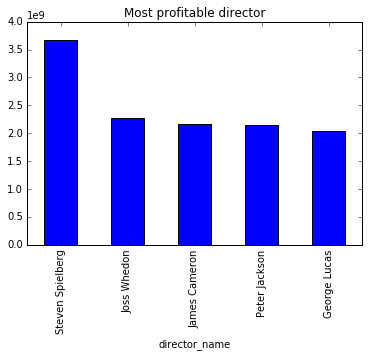

In [355]:
raw_df.groupby('director_name')\
      .sum()\
      .sort_values(by='gross',ascending=False)\
      .head()['gross'].plot(kind='bar',title="Most profitable director")

Revenue is not enough, we are actually interested in revenue/budget.

Normalized by budget: (Director with highest ROI)

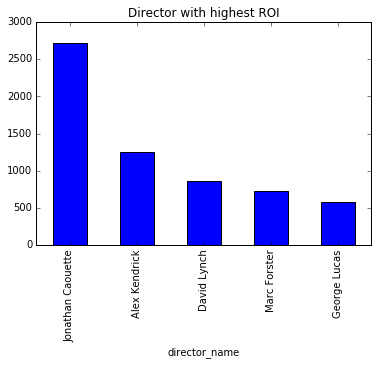

In [356]:
raw_df['gross_d_budget'] = raw_df['gross'] / raw_df['budget']
raw_df.groupby('director_name')\
      .sum()\
      .sort_values(by='gross_d_budget',ascending=False)\
      .head()['gross_d_budget'].plot(kind='bar',title="Director with highest ROI")

Directors with few movies do not have enough experience. Let's look only at directors with more than 5 movies:

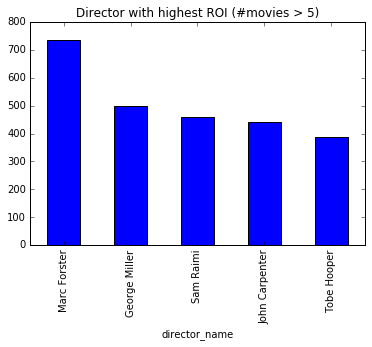

In [359]:
raw_df['dummy_count'] = 1 #Easier than count..
raw_df.groupby('director_name')\
      .sum()\
      .query('dummy_count > 5')\
      .sort_values(by='gross_d_budget',ascending=False)\
      .head()['gross_d_budget'].plot(kind='bar',title="Director with highest ROI (#movies > 5)")

The sum of gross/budget isn't actually a good enough measure for success. Here is the example:

In [360]:
top_dirs = raw_df.groupby('director_name')\
      .sum()\
      .query('dummy_count > 5')\
      .sort_values(by='gross_d_budget',ascending=False)\
      .head().index

In [361]:
top_dirs

Index([u'Marc Forster', u'George Miller', u'Sam Raimi', u'John Carpenter',
       u'Tobe Hooper'],
      dtype='object', name=u'director_name')

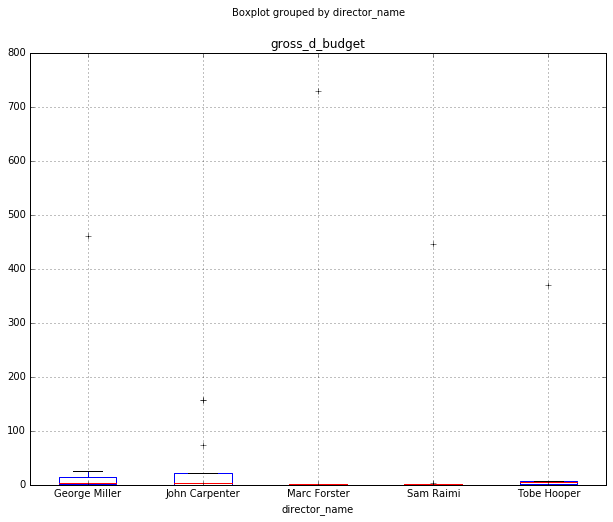

In [362]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
raw_df.set_index('director_name').loc[top_dirs].reset_index().boxplot(column='gross_d_budget',by='director_name',ax=ax)

For most directors in the plot, we can see there are outliers , very far from the mean.
One incredibly successful film can bias our decision. We want a more reliable investment, in a director that has a more certain ROI. Let's examine the director high the higest mean (and more than 5 films)

In [363]:
more5_films = raw_df.set_index('director_name').loc[raw_df.groupby('director_name').count().reset_index().query('gross > 5')['director_name']].reset_index()

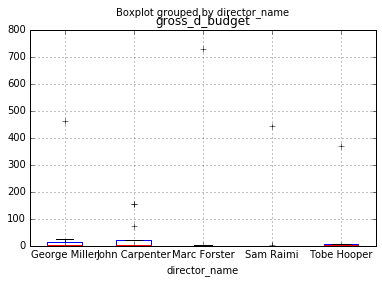

In [364]:
top_dirs = more5_films.groupby('director_name')\
      .mean()\
      .sort_values(by='gross_d_budget',ascending=False)\
      .head().index;
raw_df.set_index('director_name').loc[top_dirs].reset_index().boxplot(column='gross_d_budget',by='director_name')

Still, in our list there are directors with outliers that could bias our decision. let's discard the ones with std higher than the mean-std (we are interested in a solid investment)

In [373]:
mean_std = more5_films.std()['gross_d_budget']
solid_directors = more5_films.groupby('director_name').std().query('gross_d_budget < '+str(mean_std)).index

In [387]:
top_dirs = more5_films.set_index('director_name').loc[solid_directors].reset_index()\
.groupby('director_name')\
.mean()\
.sort_values(by='gross_d_budget',ascending=False)[:5].index

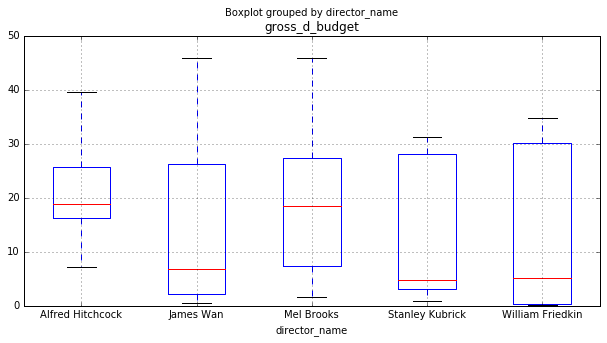

In [392]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
more5_films.set_index('director_name').loc[top_dirs].reset_index().boxplot(column='gross_d_budget',by='director_name',ax=ax)

**Conclusion:**
According to this analysis, Alfred Hitchcock has the best ROI, Mel Brooks is probably next. 
Since A.Hitchcock isn't active, we may want to continue screening for directors who are active in the last years, have an upward trend in gross/budget and lower std.